In [327]:
# Importing neccessary modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pytesseract
import re
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [328]:
# Define the paths to the image and template
image_path = './resources/slika7.jpg'
template_path = './templates/ZG-template2.jpg'

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Image file not found at {image_path}")
else:
    print(f"Image file found at {image_path}")

# Check if the template file exists
if not os.path.exists(template_path):
    print(f"Template file not found at {template_path}")
else:
    print(f"Template file found at {template_path}")

Image file found at ./resources/slika7.jpg
Template file found at ./templates/ZG-template.jpg


Image loaded successfully.
Template loaded successfully.


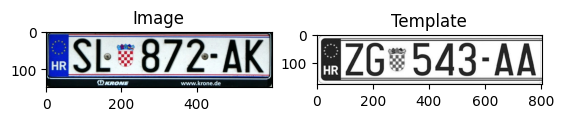

In [329]:
# Load the image and template
image = cv2.imread(image_path)
template = cv2.imread(template_path, 0)  # Load template in grayscale

# Create figure
fig = plt.figure()

# Setting values to rows and column variables
rows = 1
columns = 2

if image is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully.")
    fig.add_subplot(rows, columns, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Image")

if template is None:
    print("Failed to load template.")
else:
    print("Template loaded successfully.")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(template, cmap='gray')  # Display grayscale image
    plt.title("Template")

Image dimensions: 600x148
Template dimensions: 805x178
Resized template dimensions: 600x132
max_val = 0.39564311504364014
Raw detected plate text: al SE@ 872K
Formatted plate text:  SE 872K



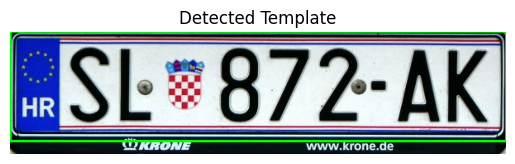

In [330]:
# Proceed only if both image and template are loaded successfully
if image is not None and template is not None:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Check if the conversion was successful
    if gray_image is None:
        print("Error converting image to grayscale")
    else:
        # Preprocess the image and template
        gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        gray_template = cv2.GaussianBlur(template, (5, 5), 0)

    # Check the dimensions of the images
    img_height, img_width = gray_image.shape
    tmpl_height, tmpl_width = gray_template.shape

    print(f"Image dimensions: {img_width}x{img_height}")
    print(f"Template dimensions: {tmpl_width}x{tmpl_height}")

    # Resize the template if it is larger than the image
    if tmpl_height > img_height or tmpl_width > img_width:
        scale_factor = min(img_height / tmpl_height, img_width / tmpl_width)
        new_tmpl_height = int(tmpl_height * scale_factor)
        new_tmpl_width = int(tmpl_width * scale_factor)
        gray_template = cv2.resize(gray_template, (new_tmpl_width, new_tmpl_height))
        print(f"Resized template dimensions: {new_tmpl_width}x{new_tmpl_height}")

    # Perform template matching using grayscale images
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)

    # Set a lower threshold for detection
    threshold = 0.1

    # Find the maximum correlation score (max_val) and its location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    print(f"max_val = {max_val}")

    # Draw a rectangle around the matched region if the match is above the threshold
    if max_val >= threshold:
        top_left = max_loc
        h, w = gray_template.shape
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

        # Extract the detected plate region
        detected_plate = gray_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

        # Additional preprocessing on the detected plate region
        detected_plate = cv2.threshold(detected_plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Apply edge detection
        edges = cv2.Canny(detected_plate, 100, 200)

        # Use pytesseract to extract text from the detected plate region
        plate_text = pytesseract.image_to_string(edges, config='--psm 8')  # PSM 8 is for single word/line
        print(f"Raw detected plate text: {plate_text.strip()}")

        # Post-process the OCR result to match the expected format
        formatted_plate_text = re.sub(r'[^A-Z0-9\s\-.]', '', plate_text)

        print(f"Formatted plate text: {formatted_plate_text}")
        # Display the result using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Detected Template')
        plt.axis('off')  # Hide axes
        plt.show()

    else:
        print("No match found above the threshold.")